In [1]:
import tensorflow as tf
import librosa
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import skimage.io as io
import pandas as pd
import os
%load_ext tensorboard

In [2]:
batch_size = 32

img_width = 1024
img_height = 128

train_directory = 'data/GTZAN/mel_images/train'
test_directory = 'data/GTZAN/mel_images/test'

train_ds = tf.keras.utils.image_dataset_from_directory(directory=train_directory,
                                                       validation_split=0.2,
                                                       subset='training',
                                                       seed=42,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                       color_mode='grayscale'
                                                        )

val_ds = tf.keras.utils.image_dataset_from_directory(directory=test_directory,
                                                     validation_split=0.2,
                                                     subset='validation',
                                                     seed=42,
                                                     image_size=(img_height, img_width),
                                                     batch_size=batch_size,
                                                     color_mode='grayscale'
                                                    )

Found 800 files belonging to 10 classes.
Using 640 files for training.
Found 199 files belonging to 10 classes.
Using 39 files for validation.


In [3]:
def augment_using_ops(images, labels):
    scale=1./255
    images=images*scale
    return (images, labels)

train_ds = train_ds.cache().map(augment_using_ops, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().map(augment_using_ops, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [221]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, Reshape, Conv2DTranspose, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


steps_per_epoch = len(train_ds)

validation_steps = len(val_ds)

opt = Adam(learning_rate=0.001)


class Autoencoder(tf.keras.Model):
    
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Sequential([
            Conv2D(input_shape=(img_height, img_width, 1), filters=32, kernel_size=(3,3), padding="same", activation="relu"),
            MaxPool2D(pool_size=(4,4),padding= 'same'),
            Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
            MaxPool2D(pool_size=(4,4), padding= 'same'),
            Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
            MaxPool2D(pool_size=(4,4), padding= 'same'),
            Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
            MaxPool2D(pool_size=(4,4), padding= 'same'),
            Flatten(),
            Dense(units=latent_dim)
        ])
        self.decoder = Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            Dense(units=1024,activation="relu"),
            Reshape(target_shape=(1,4,256)),
            Conv2DTranspose(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
            UpSampling2D((2,4)),
            Conv2DTranspose(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
            UpSampling2D((4,4)),
            Conv2DTranspose(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
            UpSampling2D((4,4)),
            Conv2DTranspose(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
            UpSampling2D((4,4)),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding="same",),
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = Autoencoder(256)

def loss(model, original):
    reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(model(original), original)))
    return reconstruction_error

def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        gradients = tape.gradient(loss(model, original), model.trainable_variables)
        gradient_variables = zip(gradients, model.trainable_variables)
        opt.apply_gradients(gradient_variables)
        
writer = tf.summary.create_file_writer('tmp')

epochs = 20

In [222]:
with writer.as_default():
    with tf.summary.record_if(True):
        for epoch in range(epochs):
            for step, batch_features in enumerate(train_ds):
                batch_features = batch_features[0]
                train(loss, autoencoder, opt, batch_features)
                loss_values = loss(autoencoder, batch_features)
#                 original = tf.reshape(batch_features, (batch_features.shape[0], 128, 1024, 1))
#                 reconstructed = tf.reshape(autoencoder(tf.constant(batch_features)), (batch_features.shape[0], 128, 1024, 1))
#                 tf.summary.scalar('loss', loss_values, step=step)
#                 tf.summary.image('original', original, max_outputs=10, step=step)
#                 tf.summary.image('reconstructed', reconstructed, max_outputs=10, step=step)
                print(f'epoch: {epoch+1}, step: {step+1}/{steps_per_epoch}, loss: {round(float(loss_values), 5)}       ', end='\r')
            print('\n')

epoch: 1, step: 20/20, loss: 0.12255       

epoch: 2, step: 20/20, loss: 0.03735       

epoch: 3, step: 20/20, loss: 0.0299        

epoch: 4, step: 20/20, loss: 0.02971       

epoch: 5, step: 20/20, loss: 0.02911       

epoch: 6, step: 20/20, loss: 0.03084       

epoch: 7, step: 20/20, loss: 0.02854       

epoch: 8, step: 20/20, loss: 0.02972       

epoch: 9, step: 20/20, loss: 0.02856       

epoch: 10, step: 20/20, loss: 0.0279        

epoch: 11, step: 20/20, loss: 0.02908       

epoch: 12, step: 20/20, loss: 0.02691       

epoch: 13, step: 20/20, loss: 0.02647       

epoch: 14, step: 20/20, loss: 0.02545       

epoch: 15, step: 20/20, loss: 0.02741       

epoch: 16, step: 20/20, loss: 0.02693       

epoch: 17, step: 20/20, loss: 0.02572       

epoch: 18, step: 20/20, loss: 0.0259        

epoch: 19, step: 20/20, loss: 0.02557       

epoch: 20, step: 20/20, loss: 0.02694       



In [231]:
test_img = np.array(Image.open('data/test_img.png').resize((1024,128)))
test_img = test_img * 1./255
test_img = test_img.reshape(1, 128, 1024, 1)

prediction = autoencoder(test_img)

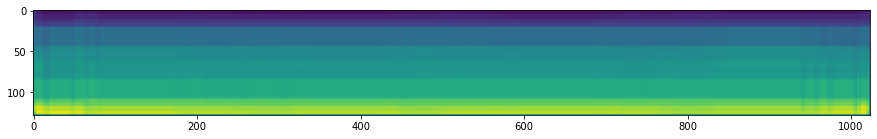

In [256]:
plt.figure(figsize=(15,15))
plt.imshow(np.array(prediction[0]*255, dtype=np.uint8))